In [1]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
import cv2

import clustering
import seq2seq
import utils as ut
import pam

ImportError: No module named clustering

In [2]:
DATA_PATH = "data/laurier/"
DATA_BASE = DATA_PATH + "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "laurier.jpg"
VIDEO_PATH = DATA_PATH + "laurier.avi"
HOMOGRAPHY = DATA_PATH + "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

In [13]:
DATA_PATH = "data/grl/"
DATA_BASE = DATA_PATH + "grl.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "grl.png"
VIDEO_PATH = DATA_PATH + "grl.MOV"
HOMOGRAPHY = DATA_PATH + "homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

# Get data for the three approaches

## Get pixel trajectories

In [4]:
c = clustering.Clustering(DATA_BASE, HOMOGRAPHY)
c.get_trajectories(pixels = 1)
trajectories = [trajectory.pixel_trajectory for trajectory in c.trajectories]

### Extract and standardize features for regular clustering

In [74]:
c.extract_features()
c.standardize_features()

ef_data = pd.DataFrame([trajectory.standardized_features for trajectory in c.trajectories])
ef_data.to_csv(SAVE_PATH + "extracted_features.csv")

###  Discretize pixel trajectories then compute or load a distance matrix for the DTW approach

In [ ]:
c.discretize_pixel_trajectories(square_side_size = 50)
discretized_trajectory = [trajectory.discretized_trajectory for trajectory in c.trajectories]

c.compute_dtw_distance_matrix(mask = 1)

### Compute features, transform them using sliding boxes the normalize

In [75]:
diff_x,diff_y,diff_v,diff_r = seq2seq.extract_features(trajectories)
seq2seq_features = [seq2seq.behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i]) for i in range(len(diff_x))]

seq2seq_data = seq2seq.minmax_scale_append_eos(seq2seq_features)

####  Train the network and save the results

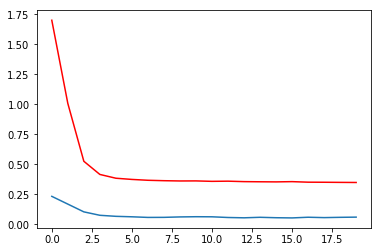

duration: 38.8360629082


In [76]:
seq2seq_data = seq2seq.seq2seq(seq2seq_data)
seq2seq_data.to_csv(SAVE_PATH + "unified_trajectory_seq2seq.csv")

#### Load the results

In [5]:
ef_data = pd.read_csv(SAVE_PATH + "extracted_features.csv")
c.load_dtw_distance_matrix(DISTANCES)
seq2seq_data = pd.read_csv(SAVE_PATH + "unified_trajectory_seq2seq.csv")

# Clustering

In [6]:
data = seq2seq_data

In [84]:
data = ef_data

In [26]:
data = c.distance_matrix

In [7]:
nb_clusters = 8

## K-means (not available for dtw approach)

In [8]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=nb_clusters, random_state=0).fit_predict(data)

## Hierarchical

#### Seq2seq and extracted features approches

In [89]:
from sklearn.cluster import AgglomerativeClustering
clusters = AgglomerativeClustering(n_clusters=nb_clusters).fit_predict(data)

#### DTW approach

In [39]:
from scipy.cluster.hierarchy import linkage, ward, fcluster
from scipy.spatial.distance import squareform

Z = linkage(squareform(c.distance_matrix), 'ward')
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

## DBSCAN

#### Seq2seq and extracted features approches

In [24]:
def outliers_prop(clusters):
    count = 0
    for j in clusters:
        if j == -1:
            count += 1
    return float(count)/float(len(clusters))

In [27]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(data)

#### DTW approach

In [30]:
clusters = DBSCAN(eps=0.5, min_samples=5,metric='precomputed').fit_predict(data)

In [31]:
outliers_prop(clusters)

0.9693080357142857

## PAM

In [43]:
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(data.as_matrix(),metric="manhattan")

/home/laurent/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [48]:
medoids_idx, clusters =pam.pam(distance_matrix, 10)

cost: 311201.0078835444
cost: 128798.42115714212
cost: 127264.61801044202
cost: 127130.84458971785
cost: 127130.84458971785


In [49]:
pd.DataFrame(medoids_idx).to_csv(SAVE_PATH + "medoids_ef_10.csv")
pd.DataFrame(clusters).to_csv(SAVE_PATH + "clusters_ef_10.csv")

In [71]:
medoids_idx = pd.read_csv(SAVE_PATH +  "medoids_ef_8.csv").values[:,1]

clusters = pd.read_csv(SAVE_PATH +  "clusters_ef_8.csv").values[:,1]


## GMM (not available for dtw approach)

In [204]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = nb_clusters).fit(data)
clusters = gmm.predict(data)
probas = gmm.score_samples(data)

(array([  1.,   2.,   3.,  16.,  61., 145., 158., 334., 543., 529.]),
 array([-88.84910251, -70.11768511, -51.3862677 , -32.6548503 ,
        -13.92343289,   4.80798451,  23.53940191,  42.27081932,
         61.00223672,  79.73365412,  98.46507153]),
 <a list of 10 Patch objects>)

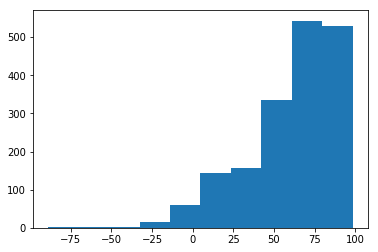

In [205]:
plt.hist(probas)

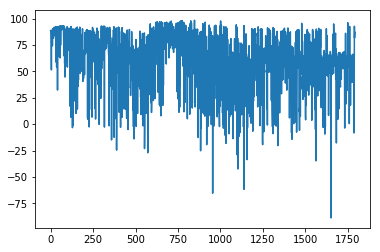

In [206]:
plt.plot(probas)

In [207]:
ids = ut.get_outliers(25, probas)

nb outliers: 236


# Display results 

### Display GMM outliers

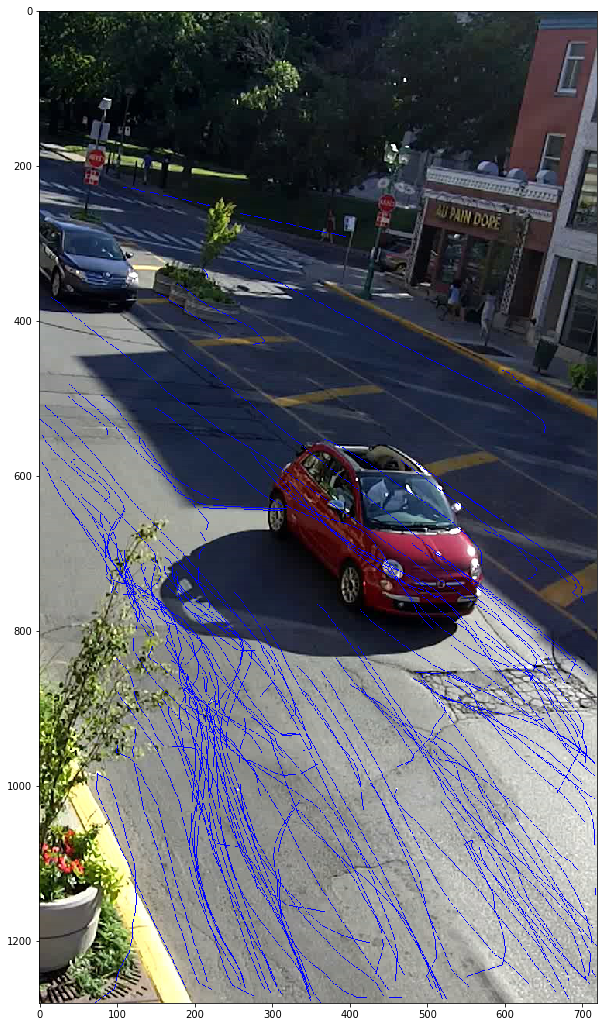

In [200]:
ut.plot_ids(ids,FRAME_PATH,trajectories)

### clustering on the outliers

In [208]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 4).fit(data.iloc[ids])
clusters_ = gmm.predict(data.iloc[ids])
probas_ = gmm.score_samples(data.iloc[ids])

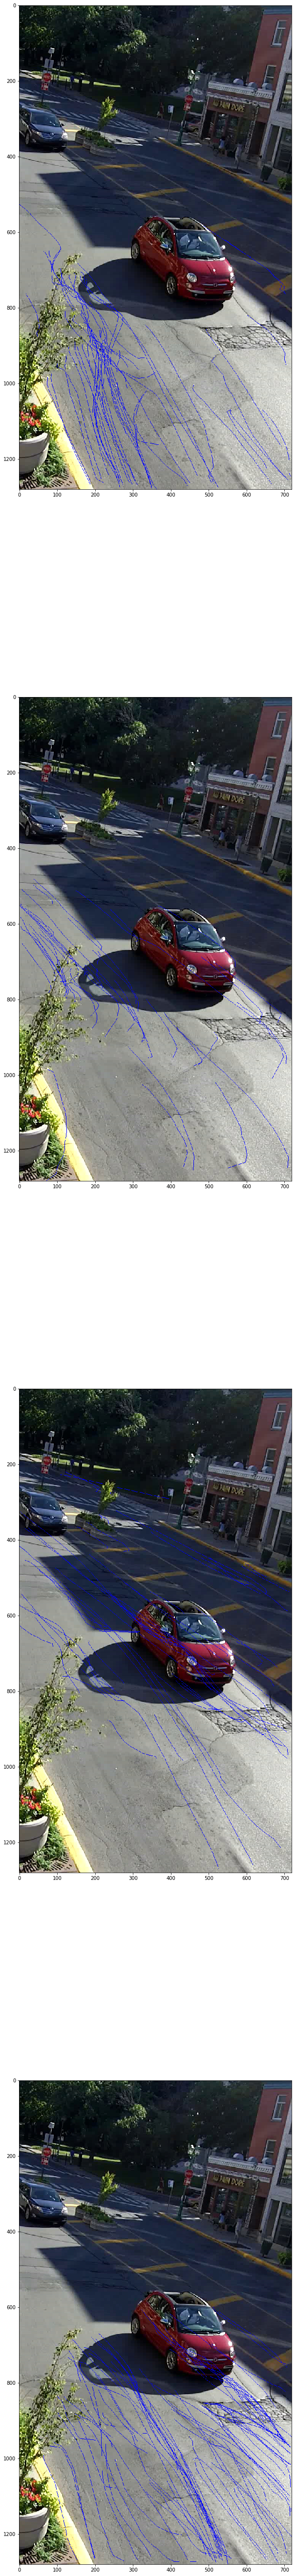

In [209]:
# visualize clusters oat inpage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import cv2
traj = np.array(trajectories)[ids]
ut.display_clusters_oat_i(clusters_,FRAME_PATH,traj)

### Display 2D projection of results for PAM algorithm(with centroids)

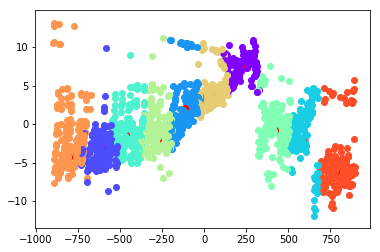

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)

medoids = principalComponents[medoids_idx]
pam.display_pam_results_2D(principalComponents,nb_clusters,clusters, medoids, display_medoids = True)

### Display clusters one after the other in the page

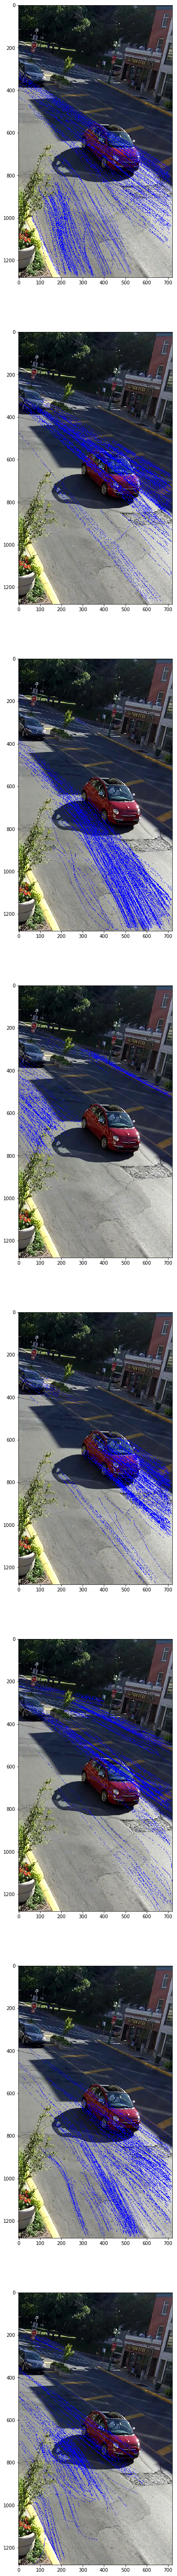

In [9]:
# visualize clusters oat inpage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import cv2
ut.display_clusters_oat_i(clusters,FRAME_PATH,trajectories)


### Display clusters one after the other outside the page

In [12]:
# visualize clusters oat outpage
ut.display_clusters_oat(clusters,VIDEO_PATH,trajectories)

### Display all the clusters at once out of the page

In [45]:
# visualize clusters aao outpage
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
ut.display_clusters_aao(clusters,VIDEO_PATH,trajectories,colors)

### Display the resulting clusters in 2D using PCA

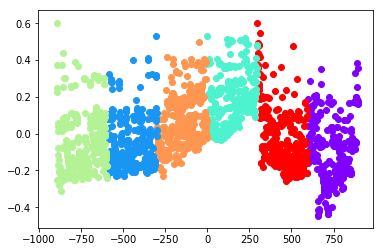

In [14]:
ut.show_clustering_results_2D(clusters,data,nb_clusters)